# Shor's algorithm in linear optics

This notebook reproduces a simulation in Perceval of a 4-qubit 12-modes optical experiment performing Shor's algorithm, based on Alberto Politi, Jonathan C.F. Matthews, and Jeremy L. O'brien. "Shor’s quantum factoring algorithm on a photonic chip." [Science](https://www.science.org/doi/10.1126/science.1173731) 325.5945 (2009): 1221-1221.

## Shor's algorithm

The purpose of Shor's algorithm is to find nontrivial factors of a given number $N$ in polynomial time, yielding an near-exponential speedup compared to state of the art classical algorithms.

The main routine of Shor's algorithm consists in finding the order $r$ of a number $a \in \mathbb{Z}_N$, i.e. the smallest integer $r$ such that $a^r = 1 \pmod N$.

If the order of a randomly chosen $a$ which is coprime with $N$ is even, then $(a^{r/2} - 1)(a^{r/2} + 1) = k N$. If none of these factors are multiples of $N$, then $\gcd(N, a^{r/2} - 1)$ and $\gcd(N, a^{r/2} + 1)$ are nontrivial factors of $N$.

## Preliminaries

In [1]:
import perceval as pcvl
from perceval.algorithm import Analyzer
from perceval import Experiment, Port, Encoding, catalog, FockState, LogicalState, BS, PostSelect, Processor

### Path encoding functions

The following functions allow for conversion between the qubit and Fock state representations.

In [2]:
def to_logical_state(fock_state):
    logical_repr = []
    for i in range(fock_state.m // 2):
        if fock_state[2*i:2*i+2] == FockState([1, 0]):
            logical_repr.append(0)
        elif fock_state[2*i:2*i+2] == FockState([0, 1]):
            logical_repr.append(1)
        else:
            raise ValueError(f"Fock state {fock_state} has no logical representation")
    return LogicalState(logical_repr)

## The circuit

### Quantum circuit

The quantum circuit has been optimized after choosing parameters $N = 15$ and $a = 2$, and aims to calculate $r=4$.
It features 5 qubits labelled $x_0, x_1, x_2$ and $f_1, f_2$. Qubits $x_i$ and $f_1$ are initially in state $|0\rangle$, and $f_2$ in state $|1\rangle$.
In the non-optimised Shor algorithm, qubits $x_i$ encode a binary number representing a pre-image of the Modular Exponentiation Function (MEF) $x \mapsto a^x \pmod N$, while qubits $f_i$ hold the image obtained after applying the MEF to qubits $x_i$. Applying the MEF when qubits $x_i$ hold a superposition of different pre-images (obtained with H gates on qubits $x_i$) allows to efficiently compute the order $r$ of parameter $a$ modulo $N$.

The circuit consists of $\mathsf{H}$ gates being first applied to each $x_i$ qubit, followed by $\mathsf{CNOT}$ gates applied on $x_1, f_1$ and $x_2, f_2$ pairs, where $x_i$ are control qubits; finally the inverse $\mathsf{QFT}$ algorithm is applied on qubits $x_i$.

$\mathsf{CNOT}$ gates on $x_i, f_i$ pairs ($x_i$ being the control) are implemented using $\mathsf{H}$ and $\mathsf{CZ}$ gates: the $\mathsf{CZ}$ gate is sandwiched between two applications of $\mathsf{H}$ on $f_i$.

The input state of the circuit after optimisation is $|0\rangle_{x_0}|0\rangle_{x_1}|0\rangle_{x_2}|0\rangle_{f_1}|1\rangle_{f_2}$.

The expected output state is then $\frac{1}{2} |0\rangle_{x_0} \otimes \left ( |0\rangle_{x_1}|0\rangle_{f_1} + |1\rangle_{x_1}|1\rangle_{f_1} \right ) \otimes \left ( |0\rangle_{x_2}|1\rangle_{f_2} + |1\rangle_{x_2}|0\rangle_{f_2} \right )$.

### Photonic circuit

The optical circuit from the result by Politi et al features twelve modes (ordered from 0 to 11 from top to bottom).

During the execution, qubit $x_0$ remains unentangled from the other qubits. It can therefore be removed from the optical implementation.

The qubits $x_1, x_2, f_1, f_2$ are path encoded as modes $(0, 1)$, $(4, 5)$, $(2, 3)$, $(6, 7)$ respectively. Four other modes are used as ancillary modes to implement the $\mathsf{CZ}$ gates.

With path encoding each $\mathsf{H}$ gate in the quantum circuit is implemented with a beam splitter with reflectivity $R=1/2$ between the two paths corresponding to the qubit. In our implementation in Perceval, phase shifters are added to properly tune the phase between each path.

$\mathsf{CZ}$ gates are implemented with three beam splitters with reflectivity $R=2/3$ acting on six modes: one inner beam splitter creates interference between the two qubits, and two outer beam splitters balance detection probability using auxiliary modes.
This optical implementation successfully yields the output state produced by a $\mathsf{CZ}$ gate with probability 1/9; otherwise it creates a dummy state, which will be automatically removed by post-selection.

In the case $r=4$ the QFT can be performed classically and doesn't need to be implemented in the photonic circuit.

## In perceval

### Implementing the circuit

Optical circuit for Shor's algorithm


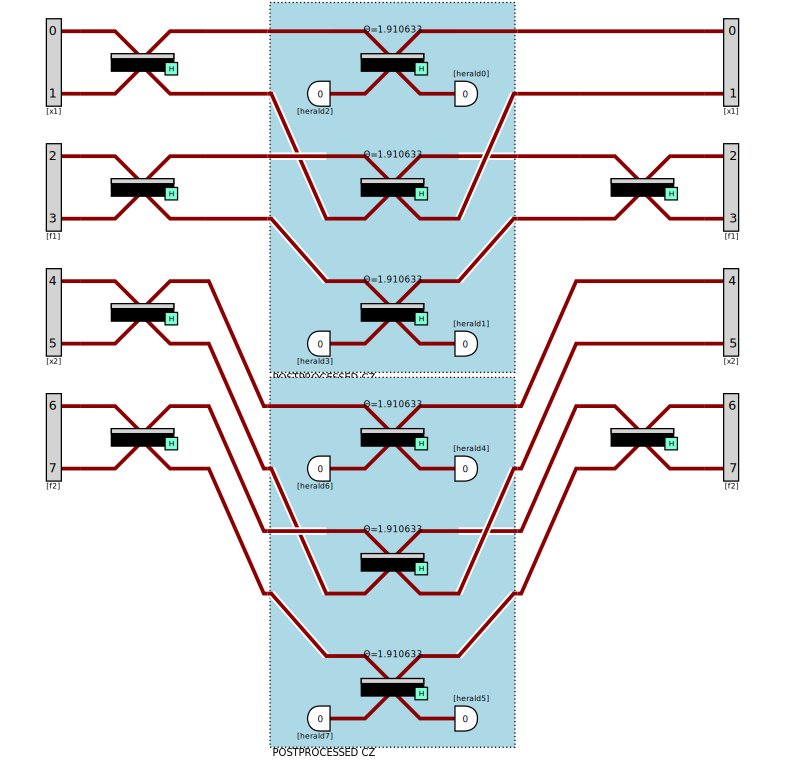

In [3]:
def create_cz(port_names):
    cz_circuit = catalog["postprocessed cz"].build_circuit()
    cz = Experiment(cz_circuit)
    (cz.add_port(0, Port(Encoding.DUAL_RAIL, port_names[0]))  # Add 1st dual rail encoded qubit
       .add_port(2, Port(Encoding.DUAL_RAIL, port_names[1]))  # Add 2nd dual rail encoded qubit
       # Add ancillary modes expecting 0 detected photon
       .add_herald(4, 0)
       .add_herald(5, 0))
    return cz


# Create the experiment implementing Shor algorithm
experiment = Experiment(8)
cz1 = create_cz(["x1", "f1"])
cz2 = create_cz(["x2", "f2"])
h = BS.H()

for i in range(0, 8, 2):
    experiment.add(i, h)

experiment.add(0, cz1)
experiment.add(4, cz2)

experiment.add(2, h)
experiment.add(6, h)

# Set up a post-selection function ensuring dual rail encoding
experiment.set_postselection(PostSelect("[0,1]==1 and [2,3]==1 and [4,5]==1  and [6,7]==1"))

print("Optical circuit for Shor's algorithm")
pcvl.pdisplay(experiment, recursive=True)

In [4]:
print("The associated matrix")
pcvl.pdisplay(experiment.unitary_circuit().compute_unitary(use_symbolic=False))

The associated matrix


<IPython.core.display.Math object>

### Input state

In the preliminaries we provided functions to map qubit states to the corresponding Fock states and vice-versa.

A *computational basis qubit state* on qubits $x_1, f_1, x_2, f_2$ is represented with a list of 4 boolean values.

A *Fock state* is represented with a list of twelve integer values.
As described above, for Fock states, the modes are enumerated as follows:
* mode pairs $(1,2), (3,4), (7,8), (9,10)$ respectively correspond to states $0,1$ for qubits $x_1, f_1, x_2, f_2$
* modes $0,5,6,11$ are auxiliary modes used for CZ gates

The input state of the circuit is $|0\rangle_{x_1}|0\rangle_{x_2}|0\rangle_{f_1}|1\rangle_{f_2}$.
With path encoding this corresponds to sending 4 photons in total in the optical circuit, in the input modes corresponding to the initial state of each qubit.

In [5]:
qubit_input_state = pcvl.LogicalState([0, 0, 0, 1])
experiment.with_input(qubit_input_state)
input_fock_state = experiment.input_state

print(f"Input qubit state: {qubit_input_state}")
print(f"Corresponding input Fock state {input_fock_state}")

Input qubit state: |0001>
Corresponding input Fock state |1,0,1,0,1,0,0,1,0,0,0,0>


## Simulation

In [6]:
simulator = pcvl.SimulatorFactory.build(experiment, "SLOS")

### Computing the output state

Using perceval we compute the output state obtained with the optical circuit.

#### Amplitudes

We first decompose the output state in the computational basis and plot the corresponding amplitudes.

In [7]:
simulator.keep_heralds(False)  # Remove ancillary modes in results
evolved_state = simulator.evolve(input_fock_state)

print("Output state amplitudes: (post-selected on qubit states, not renormalized)")
print("|x1,f1,x2,f2>")
for ouput_fock_state, amplitude in evolved_state:
    logical_state = to_logical_state(ouput_fock_state)
    print(logical_state, amplitude)

Output state amplitudes: (post-selected on qubit states, not renormalized)
|x1,f1,x2,f2>
|0010> (0.5+0j)
|1110> (0.5000000000000001+0j)
|0001> (0.49999999999999994+0j)
|1101> (0.5+0j)


The amplitudes obtained with perceval correspond to the expected output state
$$\frac{1}{2} \left ( |0\rangle_{x_1}|0\rangle_{f_1} + |1\rangle_{x_1}|1\rangle_{f_1} \right ) \otimes \left ( |0\rangle_{x_2}|1\rangle_{f_2} + |1\rangle_{x_2}|0\rangle_{f_2} \right )$$
up to numerical precision, without renormalization.

#### Distribution

We now compute the probabilities to obtain each outcome corresponding to measuring the expected output state in the computational basis.

In [8]:
input_states = {input_fock_state[:-4]: str(qubit_input_state)}

expected_output_states = {
    output_fock_state: str(to_logical_state(output_fock_state))
    for output_fock_state in evolved_state.keys()
}

p = Processor("SLOS", experiment)
ca = Analyzer(p, input_states, expected_output_states)
ca.compute()

print("Output state distribution: (post-selected on expected qubit states, renormalized)")
print("|x1,f1,x2,f2>")
pcvl.pdisplay(ca)

Output state distribution: (post-selected on expected qubit states, renormalized)
|x1,f1,x2,f2>


,|0010>,|1110>,|0001>,|1101>
|0001>,1/4,1/4,1/4,1/4


The distribution computed with Perceval is uniform over each outcome, which corresponds to the expected distribution obtained in the paper when $x_0 = 0$.

### Interpretation of the outcomes

For each outcome we consider the values of qubits $x_2, x_1, x_0$ (where $x_0$ is 0) which represent a binary number between 0 and 7, here corresponding to 0, 4, 2 and 6 in the order of the table above.
After sampling the circuit, obtaining outcomes 2 or 6 allows to successfully compute the order $r=4$.
Obtaining outcome 0 is an expected failure of the quantum circuit, inherent to Shor's algorithm.
Outcome 4 is an expected failure as well, as it only allows to compute the trivial factors 1 and 15.

Since the distribution is uniform the circuit successfully yields a successful outcome with probability 1/2. This probability can be amplified exponentially close to $1$ by sampling the circuit multiple times.

## Reference

> Alberto Politi, Jonathan C.F. Matthews, and Jeremy L. O'brien. "Shor’s quantum factoring algorithm on a photonic chip." [Science](https://www.science.org/doi/10.1126/science.1173731) 325.5945 (2009): 1221-1221.